# LSTM and GRU Models Demonstration

This notebook demonstrates LSTM and GRU models for time series prediction using PyTorch Lightning.

## Import Required Libraries

Import the necessary libraries including PyTorch, PyTorch Lightning, matplotlib, and numpy.

In [1]:
from typing import Tuple

import torch

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, TensorDataset

## Define Time Series Dataset

Create a custom dataset class for handling time series data.

In [2]:
class TimeSeriesDataset(Dataset):
    """
    Dataset class for time series data.

    Attributes:
        data (np.ndarray): Time series data.
        seq_length (int): Sequence length.
    """

    def __init__(self, data: np.ndarray, seq_length: int):
        """
        Initialize the TimeSeriesDataset.

        Args:
            data (np.ndarray): Time series data.
            seq_length (int): Sequence length.
        """
        self.data = data
        self.seq_length = seq_length

    def __len__(self) -> int:
        """
        Get the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.data) - self.seq_length

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get the item from the dataset.

        Args:
            index (int): Index of the item.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Input and output tensors.
        """
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

        return x, y

## Define LSTM Model

Create an LSTM model class using PyTorch Lightning for time series prediction.

In [3]:
class LSTMModel(pl.LightningModule):
    """
    Define the LSTM model for time series prediction.

    Attributes:
        lr (float): Learning rate for optimization.
        lstm (nn.LSTM): LSTM layer.
        fc (nn.Linear): Fully connected layer.
        criterion (nn.MSELoss): Mean squared error loss.
    """

    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int,
                 output_dim: int, lr: float = 0.01):
        """
        Initialize the LSTM model.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of hidden units in LSTM.
            layer_dim (int): Number of LSTM layers.
            output_dim (int): Number of output features.
            lr (float): Learning rate for optimization.
        """
        super(LSTMModel, self).__init__()

        # Initialize the model attributes.
        self.lr = lr

        # Initializer the model layers.
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize the loss function.
        self.criterion = nn.MSELoss()

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the LSTM model.

        Args:
            tensor (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """

        # Forward pass through LSTM layer.
        output, _ = self.lstm(tensor)

        # Forward pass through the fully connected layer.
        output = self.fc(output[:, -1, :])  # Selecting the last output

        return output

    def training_step(self, batch: list, batch_idx: int) -> torch.Tensor:
        """
        Training step for the LSTM model.

        Args:
            batch (list): Batch of input and output data.
            batch_idx (int): Batch index.

        Returns:
            torch.Tensor: Loss value.
        """

        # Delete the unused batch_idx variable.
        del batch_idx

        # Get the input and output data from the batch.
        x, y = batch

        # Forward pass through the model.
        y_hat = self.forward(x)

        # Calculate the loss.
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)

        return loss

    def configure_optimizers(self):
        """
        Configure the optimizer for the LSTM model.

        Returns:
            torch.optim.Adam: Adam optimizer.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Define GRU Model

Create a GRU model class using PyTorch Lightning for time series prediction.

In [4]:
class GRUModel(pl.LightningModule):
    """
    Define the GRU model for time series prediction.

    Attributes:
        lr (float): Learning rate for optimization.
        gru (nn.GRU): GRU layer.
        fc (nn.Linear): Fully connected layer.
        criterion (nn.MSELoss): Mean squared error loss.
    """

    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int,
                 output_dim: int, lr: float = 0.01):
        """
        Initialize the GRU model.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of hidden units in GRU.
            layer_dim (int): Number of GRU layers.
            output_dim (int): Number of output features.
            lr (float): Learning rate for optimization.
        """
        super(GRUModel, self).__init__()

        # Initialize the model attributes.
        self.lr = lr

        # Initializer the model layers.
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize the loss function.
        self.criterion = nn.MSELoss()

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GRU model.

        Args:
            tensor (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """

        # Forward pass through GRU layer.
        output, _ = self.gru(tensor)

        # Forward pass through the fully connected layer.
        output = self.fc(output[:, -1, :])  # Selecting the last output

        return output

    def training_step(self, batch: list, batch_idx: int) -> torch.Tensor:
        """
        Training step for the GRU model.

        Args:
            batch (list): Batch of input and output data.
            batch_idx (int): Batch index.

        Returns:
            torch.Tensor: Loss value.
        """

        # Delete the unused batch_idx variable.
        del batch_idx

        # Get the input and output data from the batch.
        x, y = batch

        # Forward pass through the model.
        y_hat = self.forward(x)

        # Calculate the loss.
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)

        return loss

    def configure_optimizers(self):
        """
        Configure the optimizer for the GRU model.

        Returns:
            torch.optim.Adam: Adam optimizer.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Define Prediction Function

Create a helper function to generate predictions using the trained models.

In [5]:
def predict(model: pl.LightningModule,
            data_loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    """
    Predict the output using the model.

    Args:
        model (pl.LightningModule): Model for prediction.
        data_loader (DataLoader): DataLoader for the data.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Predictions and ground truth values.
    """

    # Set the model to evaluation mode.
    model.eval()

    # Initialize the predictions and ground truth values.
    predictions = []
    ground_truth = []

    # Iterate over the data loader.
    with torch.no_grad():
        for x, y in data_loader:
            prediction = model(x)
            predictions.append(prediction.squeeze().numpy())
            ground_truth.append(y.numpy())

    return np.concatenate(predictions), np.concatenate(ground_truth)

## Set Random Seeds and Hyperparameters

Set random seeds for reproducibility and define hyperparameters.

In [6]:
# Set random seed for reproducibility.
np.random.seed(0)
torch.manual_seed(0)

# Hyperparameters.
num = 1000
seq_length = 10
max_epochs = 1

## Generate Synthetic Data

Generate synthetic sine wave data for time series prediction.

In [7]:
# Generate synthetic sine wave data.
t = np.linspace(0, 100, num)
data = np.sin(t)

# Split into train and test sets.
sample = int(num * 0.8)
train_data = data[:sample]
test_data = data[sample:]

## Create Datasets and DataLoaders

Create custom datasets and PyTorch DataLoaders for training and testing.

In [8]:
# Create Datasets and DataLoaders.
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Train LSTM Model

Initialize and train the LSTM model using PyTorch Lightning.

In [9]:
# Initialize the LSTM model and train it.
lstm_model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(lstm_model, train_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/fabricio/.miniforge3/envs/damin2025/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 41.2 K | 

Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 98.22it/s, v_num=0] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 81.58it/s, v_num=0]


## Train GRU Model

Initialize and train the GRU model using PyTorch Lightning.

In [10]:
# Initialize the GRU model and train it.
gru_model = GRUModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(gru_model, train_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | gru       | GRU     | 30.9 K | train
1 | fc        | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
31.0 K    Trainable params
0         Non-trainable params
31.0 K    Total params
0.124     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 71.43it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 25/25 [00:00<00:00, 68.89it/s, v_num=1]


## Generate Predictions

Generate predictions using both trained models.

In [11]:
# Generate predicted outputs.
lstm_predictions, ground_truth = predict(lstm_model, test_loader)
gru_predictions, _ = predict(gru_model, test_loader)

## Visualize Results

Plot the predictions and ground truth values for both LSTM and GRU models.

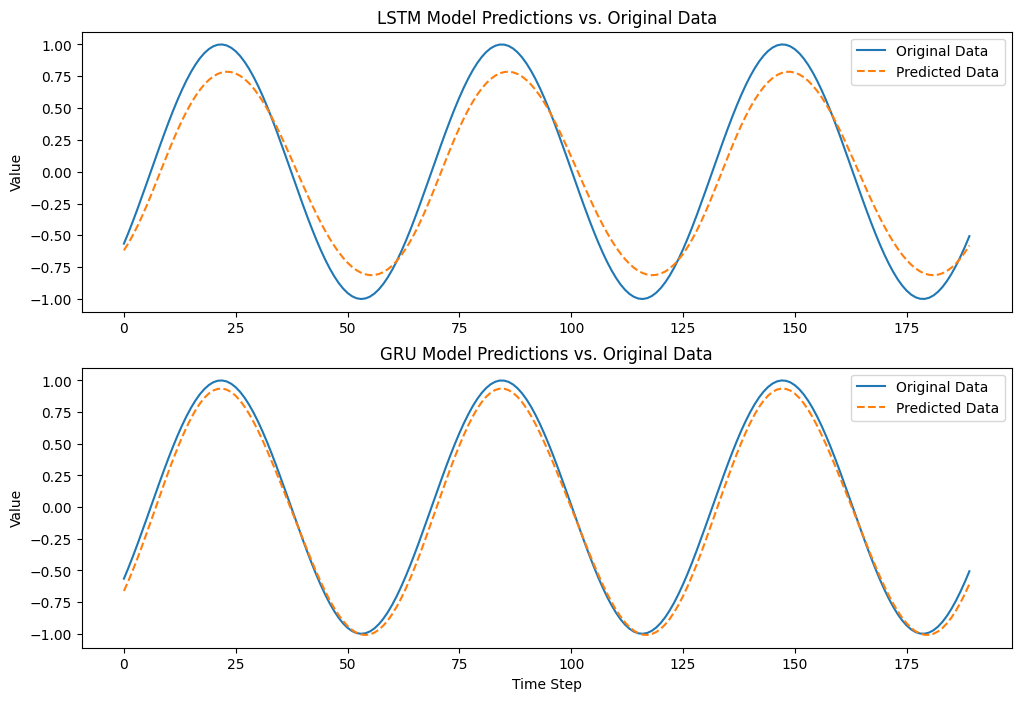

In [12]:
# Plot the predictions and ground truth values.
time_steps = np.arange(0, len(ground_truth))
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time_steps, ground_truth, label="Original Data")
plt.plot(time_steps, lstm_predictions, label="Predicted Data", linestyle="--")
plt.title("LSTM Model Predictions vs. Original Data")
plt.ylabel("Value")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_steps, ground_truth, label="Original Data")
plt.plot(time_steps, gru_predictions, label="Predicted Data", linestyle="--")
plt.title("GRU Model Predictions vs. Original Data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()

plt.show()